<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/YouTube_clickbait_multimodal_BERT_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Check GPU, if assigned k8 then factory reset couple of times until we get Tesla GPU
!nvidia-smi

Thu Aug 19 07:12:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.4 MB 4.2 MB/s 
     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 211 kB 52.5 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 636 kB 36.7 MB/s 
     |████████████████████████████████| 37.1 MB 42 kB/s 
     |████████████████████████████████| 90 kB 9.1 MB/s 
     |████████████████████████████████| 679 kB 39.0 MB/s 
     |████████████████████████████████| 99 kB 8.6 MB/s 
     |████████████████████████████████| 352 kB 36.8 MB/s 
     |████████████████████████████████| 1.2 MB 42.6 MB/s 


#Imports

In [5]:
import os, sys, math
import numpy as np
import random
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
#print("Tensorflow version " + tf.__version__)
import tensorflow_text as text
import tensorflow_addons as tfa
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
from tensorflow import keras
from official.nlp import optimization  # to create AdamW optmizer


AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

import keras
from keras import layers, regularizers, optimizers
from keras.layers import Dense, Add, Flatten, Input, Activation, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Lambda, concatenate
from keras.models import Sequential, Model, load_model
from sklearn.model_selection import StratifiedShuffleSplit
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K

from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

tf.get_logger().setLevel('ERROR')

import sys

#Import custom script
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/scripts')


import tf_dataset_helpers as dh
import vgg16_model_helper as vggh

from tf_dataset_helpers import read_tfrec_data
import model_helpers as mh
import visualization_helpers as vh


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [6]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.6.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


#Configurations

##BERT Configs

In [79]:
#@title "Model mappings"
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4'
}

In [80]:
#@title "Bert pretrained model downlaod"
tfhub_handle_encoder = map_name_to_handle[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder)

bert_layer = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='bert_encoder')
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
bert_tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4


##General config

In [81]:
TARGET_SIZE = [180, 180]
CLASSES = [b'nonclickbaits', b'clickbaits'] 
BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)
VALIDATION_SPLIT = 0.3
TESTING_SPLIT = 0.5
WIDTH = 180
HEIGHT = 180

# Label categories
label_list = [0,1]
# maximum length of (token) input sequences
max_seq_len = 128
init_lr = 2e-5

epochs = 15

In [82]:
tfrec_trainVal_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/train_val/'
tfrec_test_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/test/'
tfrec_benchmark_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/tfrec_data/'


In [83]:
#Save weights
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/mm_models/Checkpoints'
clickbait_mm_bert_xception_weights_path = os.path.join(checkpoint_filepath, 'clickbait_mm_bert_xception_weights')

#Save model
MODEL_SAVE_PATH ='/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/mm_models'
clickbait_mm_bert_xception_path = os.path.join(MODEL_SAVE_PATH, 'clickbait_mm_bert_xception_model')

In [84]:
#instantiate read_data utility
read_data = read_tfrec_data(tfrec_trainVal_files_path, TARGET_SIZE=TARGET_SIZE,  VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=2, SHUFFLE_BUFFER=17000)
read_test_data = read_tfrec_data(tfrec_test_files_path, TARGET_SIZE=TARGET_SIZE, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=2, SHUFFLE_BUFFER=1900) # Used only for testing
read_benchmark_data = read_tfrec_data(tfrec_benchmark_files_path, TARGET_SIZE=TARGET_SIZE, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=2, SHUFFLE_BUFFER=100) # Used only for benchmarking

num_training_example = 17000
# splitting data files between training, validation and test
filenames, training_filenames, validation_filenames, testing_filenames = read_data.get_tfrec_files()
testing_filenames, _, _,_ = read_test_data.get_tfrec_files()
benchmarking_filenames, _, _,_ = read_benchmark_data.get_tfrec_files()

Pattern matches 30 data files. Splitting dataset into 24 training files , 6 validation files and 0 test files
Pattern matches 2 data files. Splitting dataset into 2 training files , 0 validation files and 0 test files
Pattern matches 4 data files. Splitting dataset into 4 training files , 0 validation files and 0 test files


##Scripts

In [85]:
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_len, tokenizer=bert_tokenizer):
  example = classifier_data_lib.InputExample(guid=None, text_a=text.numpy(), text_b=None, label=label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)
  
def to_feature_map(image, text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], Tout=[tf.int32,tf.int32, tf.int32, tf.int32 ])
  input_ids.set_shape([max_seq_len])
  segment_ids.set_shape([max_seq_len])
  input_mask.set_shape([max_seq_len])
  label_id.set_shape([])

  text_feat = {
       'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids':segment_ids
  }
  
  return (image, text_feat), label_id

In [86]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        "text": tf.io.FixedLenFeature([], tf.string),
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    text = example['text']
    label  = example['label']
    return image, text, class_num, label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_batched_dataset(dataset, train=False):
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.shuffle(num_training_example)
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset

In [87]:
def create_image_model():
  base_model = tf.keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(WIDTH, HEIGHT, 3),
    include_top=False,
  )  
  # Freeze the base_model
  base_model.trainable = False
  # Create new model on top
  inputs = tf.keras.Input(shape=(WIDTH, HEIGHT, 3))

  x = tf.keras.applications.xception.preprocess_input(inputs)
  x = base_model(x, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  outputs = tf.keras.layers.Dropout(0.2)(x)
  model = tf.keras.Model(inputs, outputs)
  return model 



In [88]:
def create_bert_model():

 encoder_inputs = dict(
    input_word_ids=tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_word_ids"),
    input_mask=tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,  name="input_mask"),
    input_type_ids=tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_type_ids"),
)
 
 net = bert_layer(encoder_inputs)['pooled_output']
 
 net = tf.keras.layers.Dropout(0.2)(net)

 output = tf.keras.layers.Dense(512, activation='ReLU', name='dense_512')(net)

 model = tf.keras.Model(
     encoder_inputs,
     outputs=output,
 )
 return model

In [134]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non clickbaits Detected (True Negatives): ', cm[0][0])
  print('Non-Clickbaits Detected as Clickbaits (False Positives): ', cm[0][1])
  print('Clickbaits Detected as Non-clickbaits (False Negatives): ', cm[1][0])
  print('Clickbaits Detected (True Positives): ', cm[1][1])
  print('Total Non-clickbaits: ', np.sum(cm[0]))
  print('Total Clickbaits: ', np.sum(cm[1]))


def get_metrics(testy, y_pred):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(testy, y_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(testy, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(testy, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(testy, y_pred)
    print('F1 score: %f' % f1)
    # ROC AUC
    auc = roc_auc_score(testy, y_pred)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(testy, y_pred)
    print(matrix)


def predict_on_test(model, ds, N=1):
  test_data = ds.take(N)
  test_image=[]
  y_true=[]
  
  for (images,texts), labels in test_data:
    for i in range(BATCH_SIZE):
      test_image.append(images[i].numpy())
      y_true.append(labels[i].numpy())



  predicted_scores  = model.predict(test_data)
  y_pred = (predicted_scores > 0.5).astype("int32")
  y_pred = y_pred.reshape(-1)
  get_metrics(y_true, y_pred)
  print()
  plot_cm(y_true, predicted_scores)
  return test_image, y_true, y_pred

#Load TFRecord into TF Dataset

In [95]:
# create the TF datasets
with tf.device('/cpu:0'):
  train_ds = load_dataset(training_filenames)
  val_ds = load_dataset(validation_filenames)
  test_ds = load_dataset(testing_filenames)
  benchmark_ds = load_dataset(benchmarking_filenames)

In [96]:
with tf.device('/cpu:0'):
  train_ds = train_ds.map(lambda image, text, class_num, label:(image, text, class_num))
  val_ds = val_ds.map(lambda image, text, class_num, label:(image, text, class_num))
  test_ds = test_ds.map(lambda image, text, class_num, label:(image, text, class_num))
  benchmark_ds = benchmark_ds.map(lambda image, text, class_num, label:(image, text, class_num))

In [97]:
with tf.device('/cpu:0'):
  # train
  train_data = train_ds.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  train_data = get_batched_dataset(train_data, train=True)

  # valid
  val_data = val_ds.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  val_data = get_batched_dataset(val_data)

  # test
  test_data = test_ds.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  test_data = get_batched_dataset(test_data)

  # benchmark
  benchmark_data = benchmark_ds.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  benchmark_data = get_batched_dataset(benchmark_data)

In [98]:
train_data.element_spec, val_data.element_spec, test_data.element_spec, benchmark_data.element_spec

(((TensorSpec(shape=(None, 180, 180, 3), dtype=tf.uint8, name=None),
   {'input_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
    'input_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
    'input_word_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)}),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)),
 ((TensorSpec(shape=(None, 180, 180, 3), dtype=tf.uint8, name=None),
   {'input_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
    'input_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
    'input_word_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)}),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)),
 ((TensorSpec(shape=(None, 180, 180, 3), dtype=tf.uint8, name=None),
   {'input_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
    'input_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
    'input_word_ids': TensorSpec(shape=(None, 1

#Build Model

##Image model

In [100]:
img_model = create_image_model()
img_model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
tf.math.truediv_4 (TFOpLambd (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract_4 (TFOpLamb (None, 180, 180, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               104

##Text model

In [101]:
txt_model = create_bert_model()
txt_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_encoder (KerasLayer)       {'default': (None, 7 109482241   input_mask[0][0]                 
                                                                 input_type_ids[0][0]      

##Text-Image combined multi-modal model

In [102]:
merged=concatenate([img_model.output,txt_model.output])
out=tf.keras.layers.Dense(512, activation='relu')(merged)
out =tf.keras.layers.Dense(256, activation='relu')(out)
out =tf.keras.layers.Dense(128, activation='relu')(out)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(out)
classifier=Model([img_model.input,txt_model.input],output) 
classifier.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
tf.math.truediv_4 (TFOpLambda)  (None, 180, 180, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
tf.math.subtract_4 (TFOpLambda) (None, 180, 180, 3)  0           tf.math.truediv_4[0][0]          
__________________________________________________________________________________________________
xception (Functional)           (None, 6, 6, 2048)   20861480    tf.math.subtract_4[0][0]         
___________________________________________________________________________________________

#Compile Model

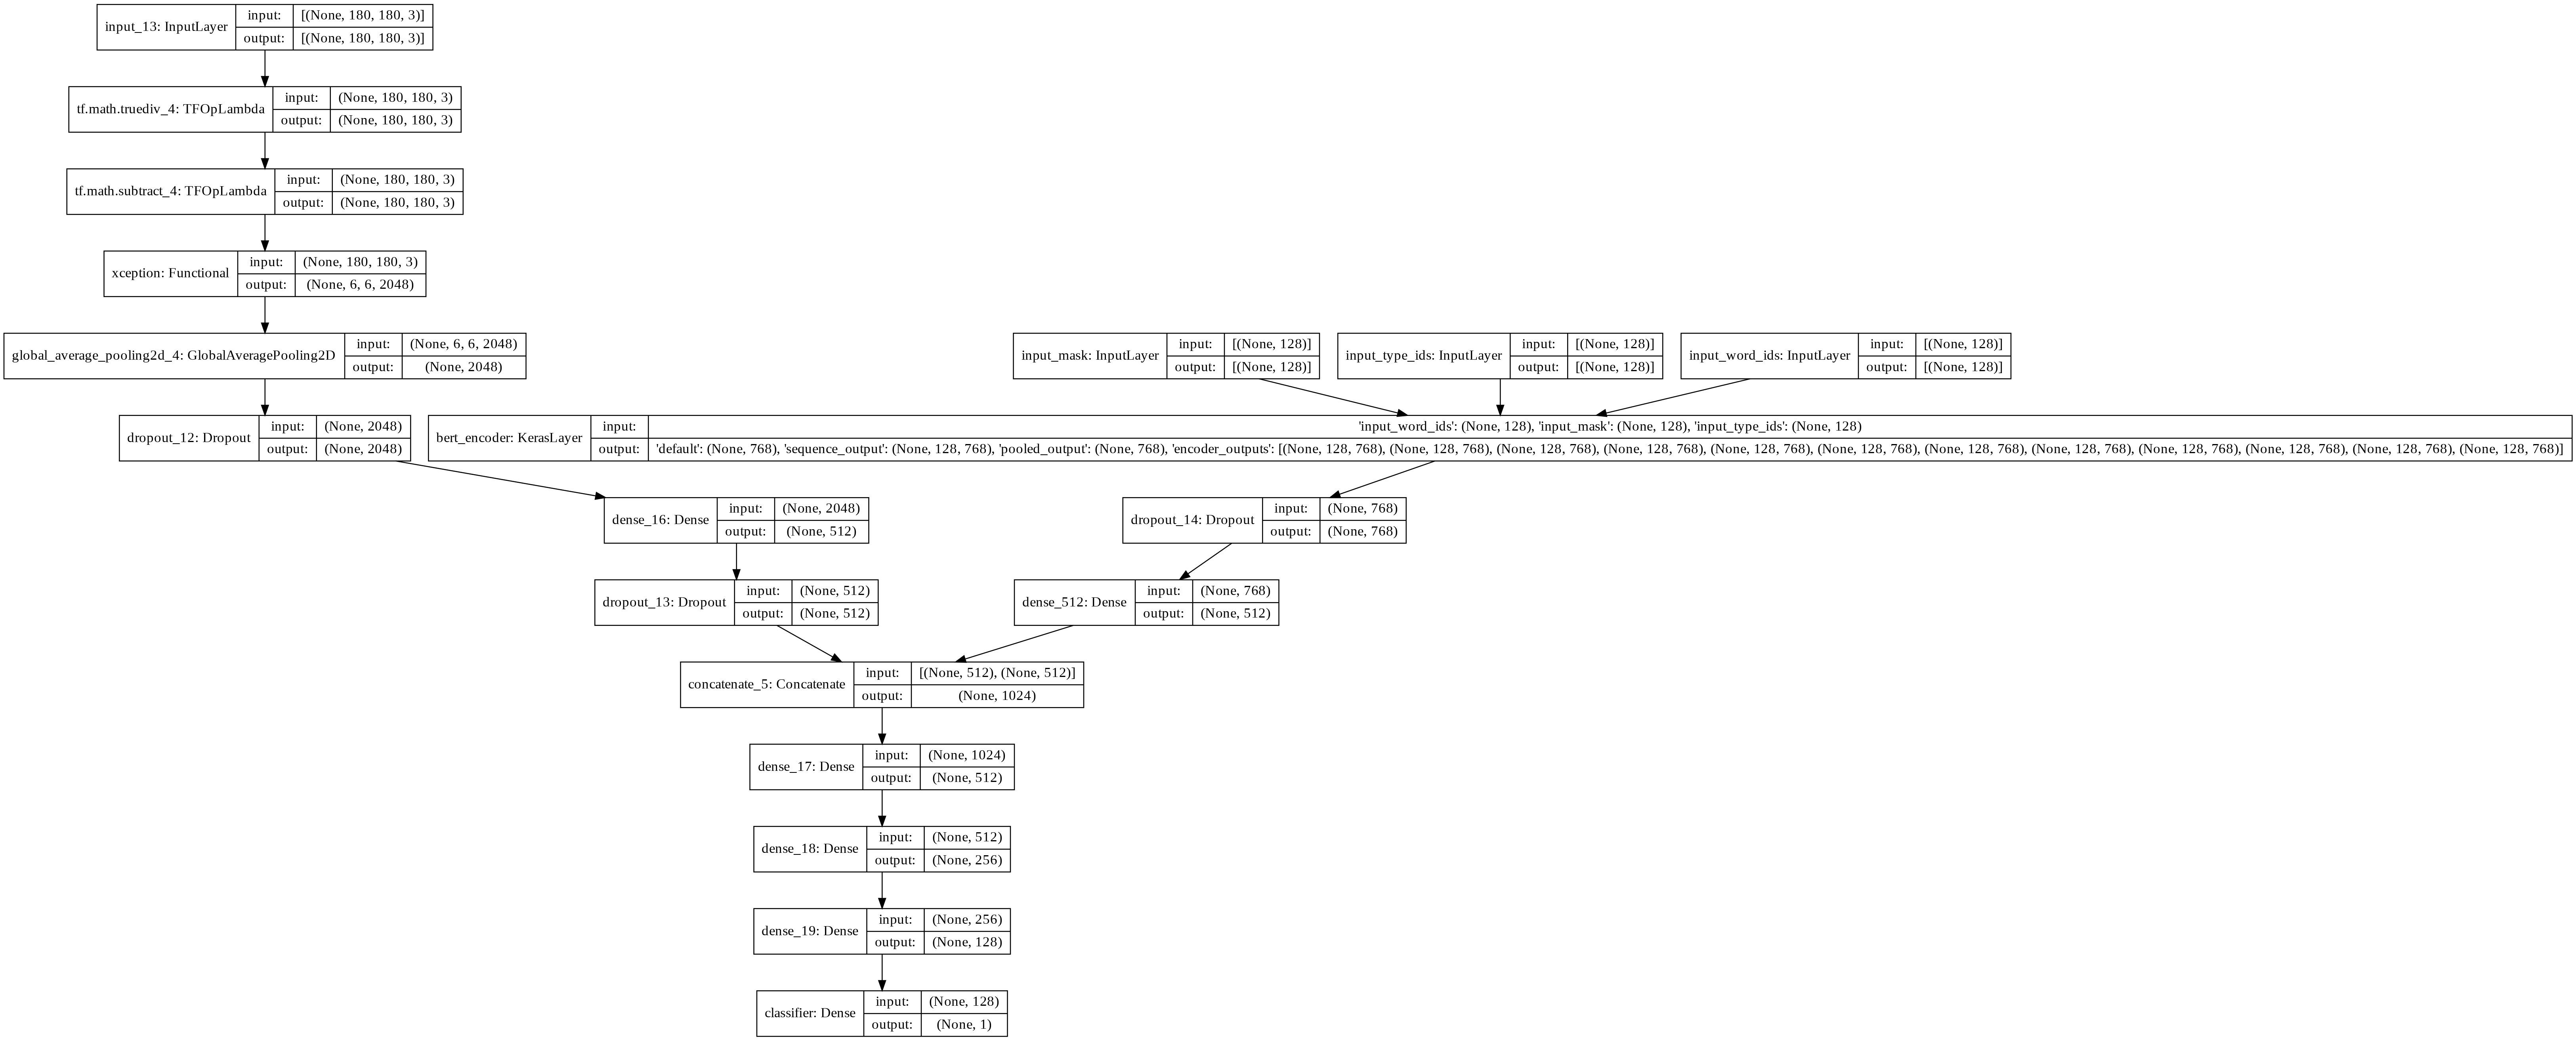

In [103]:
es = tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', 
          verbose=1, 
          patience=5, 
          mode='min', 
          restore_best_weights=True
          )

mcb = tf.keras.callbacks.ModelCheckpoint (
         filepath=clickbait_mm_bert_xception_weights_path,
         save_weights_only=True,
         monitor='val_loss',
         mode='min',
         verbose=1,
         save_best_only=True
        )

METRICS = [
             keras.metrics.TruePositives(name='tp'),
             keras.metrics.FalsePositives(name='fp'),
             keras.metrics.TrueNegatives(name='tn'),
             keras.metrics.FalseNegatives(name='fn'), 
             keras.metrics.BinaryAccuracy(name='accuracy'),
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc'),
             keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=10000,
      num_warmup_steps=1000,
      optimizer_type='adamw'
      )

classifier.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=METRICS
    )

tf.keras.utils.plot_model(model=classifier, show_shapes=True, dpi=180)

#Model Training

In [104]:
EPOCHS=30

history = classifier.fit(
  train_data,
  steps_per_epoch = 420,
  validation_data=val_data,
  validation_steps=100,
  epochs=EPOCHS,
  verbose=1,
  callbacks=[es, mcb]
)

Epoch 1/30
420/420 [==============================] - 920s 2s/step - loss: 0.4597 - tp: 4607.0000 - fp: 1026.0000 - tn: 5909.0000 - fn: 1898.0000 - accuracy: 0.7824 - precision: 0.8179 - recall: 0.7082 - auc: 0.8762 - prc: 0.8758 - val_loss: 0.1411 - val_tp: 1388.0000 - val_fp: 107.0000 - val_tn: 1665.0000 - val_fn: 40.0000 - val_accuracy: 0.9541 - val_precision: 0.9284 - val_recall: 0.9720 - val_auc: 0.9899 - val_prc: 0.9859

Epoch 00001: val_loss improved from inf to 0.14112, saving model to /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/mm_models/Checkpoints/clickbait_mm_bert_xception_weights
Epoch 2/30
420/420 [==============================] - 836s 2s/step - loss: 0.1573 - tp: 6220.0000 - fp: 395.0000 - tn: 6444.0000 - fn: 381.0000 - accuracy: 0.9423 - precision: 0.9403 - recall: 0.9423 - auc: 0.9840 - prc: 0.9829 - val_loss: 0.1102 - val_tp: 1393.0000 - val_fp: 63.0000 - val_tn: 1709.0000 - val_fn: 35.0000 - val_accuracy: 0.9694 - val_precision: 0.9567 - val_re

In [111]:
classifier.save(clickbait_mm_bert_xception_path)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Plot training history

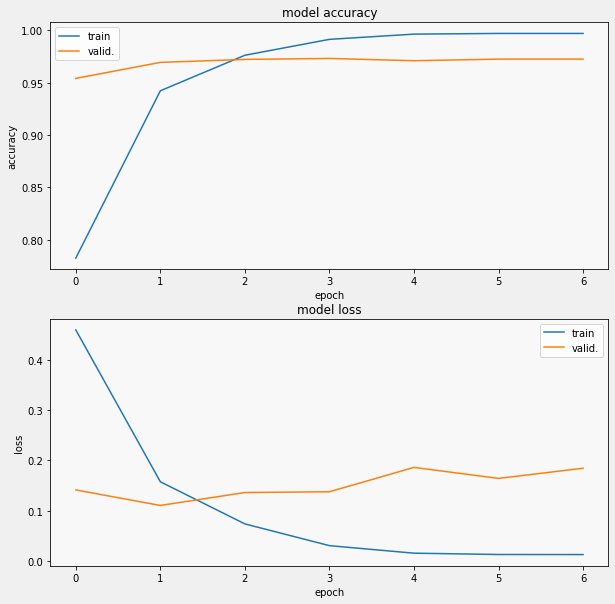

In [108]:
vh.display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

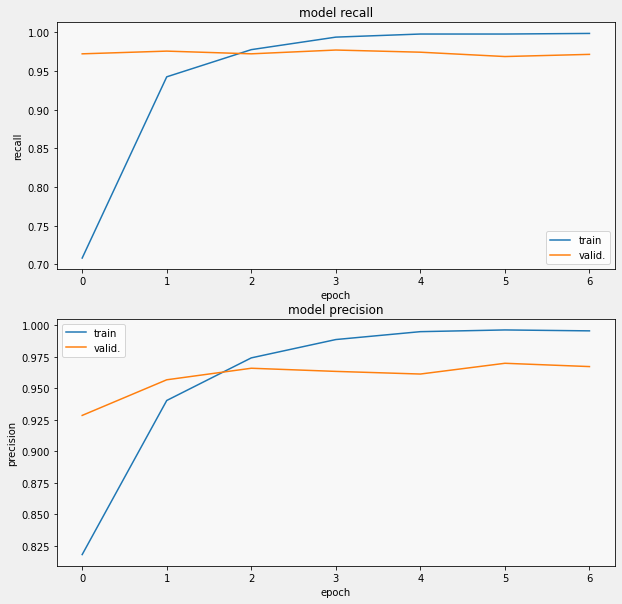

In [109]:
vh.display_training_curves(history.history['recall'], history.history['val_recall'], 'recall', 211)
vh.display_training_curves(history.history['precision'], history.history['val_precision'], 'precision', 212)

In [ ]:
display_training_curves(history.history['recall'], history.history['val_recall'], 'recall', 211)
display_training_curves(history.history['precision'], history.history['val_precision'], 'precision', 212)

#Predictions

In [131]:
results = classifier.evaluate(test_data)

for name, value in zip(classifier.metrics_names, results):
  print(name, ': ', value)
print()
  

61/61 [==============================] - 47s 771ms/step - loss: 0.1206 - tp: 892.0000 - fp: 39.0000 - tn: 997.0000 - fn: 20.0000 - accuracy: 0.9697 - precision: 0.9581 - recall: 0.9781 - auc: 0.9903 - prc: 0.9823
loss :  0.12060961127281189
tp :  892.0
fp :  39.0
tn :  997.0
fn :  20.0
accuracy :  0.9697125554084778
precision :  0.9581095576286316
recall :  0.9780701994895935
auc :  0.9903453588485718
prc :  0.9822797775268555



Accuracy: 0.962500
Precision: 0.954098
Recall: 0.966777
F1 score: 0.960396
ROC AUC: 0.962740
[[325  14]
 [ 10 291]]

Non clickbaits Detected (True Negatives):  325
Non-Clickbaits Detected as Clickbaits (False Positives):  14
Clickbaits Detected as Non-clickbaits (False Negatives):  10
Clickbaits Detected (True Positives):  291
Total Non-clickbaits:  339
Total Clickbaits:  301


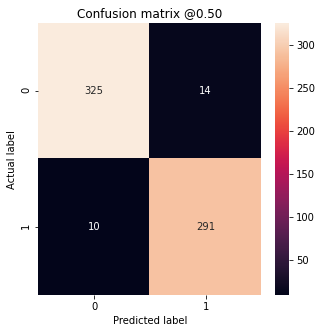

In [135]:
test_image, y_true, y_pred = predict_on_test(classifier,test_data,N=20)

#Benchmarking

In [136]:
results = classifier.evaluate(benchmark_data)

for name, value in zip(classifier.metrics_names, results):
  print(name, ': ', value)
print()
  

6/6 [==============================] - 4s 645ms/step - loss: 0.4838 - tp: 75.0000 - fp: 6.0000 - tn: 63.0000 - fn: 19.0000 - accuracy: 0.8466 - precision: 0.9259 - recall: 0.7979 - auc: 0.9201 - prc: 0.9496
loss :  0.48382699489593506
tp :  75.0
fp :  6.0
tn :  63.0
fn :  19.0
accuracy :  0.8466257452964783
precision :  0.9259259104728699
recall :  0.7978723645210266
auc :  0.9201357960700989
prc :  0.9496098756790161



Accuracy: 0.843750
Precision: 0.925926
Recall: 0.797872
F1 score: 0.857143
ROC AUC: 0.853482
[[60  6]
 [19 75]]

Non clickbaits Detected (True Negatives):  60
Non-Clickbaits Detected as Clickbaits (False Positives):  6
Clickbaits Detected as Non-clickbaits (False Negatives):  19
Clickbaits Detected (True Positives):  75
Total Non-clickbaits:  66
Total Clickbaits:  94


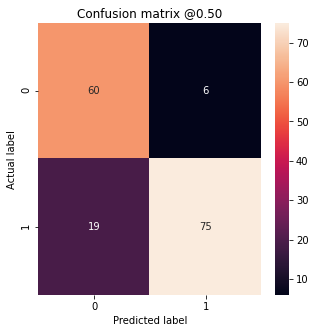

In [141]:
test_image, y_true, y_pred = predict_on_test(classifier,benchmark_data,N=5)